 # MLP CIFAR100

In [6]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.datasets as td
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

from scipy.special import entr

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

Using PyTorch version: 0.4.1.post2 CUDA: False


In [7]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./data', train=True, download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                     ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)

Files already downloaded and verified


Verifico il corretto funzionamento del dataset:

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

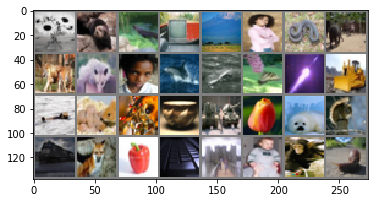

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

Uso l'80% del dataset per l'addestramento della rete, il restante 20% lo uso per fare test OOD

In [10]:
split = int(np.floor(len(train_loader.dataset.train_labels))*0.8)

#split 80% del train loader dataset
train_l = train_loader.dataset.train_labels[0:split]
train_l = torch.IntTensor(train_l)

train_d = train_loader.dataset.train_data[0:split]
train_d = torch.FloatTensor(train_d)

#split 20% del train loader dataset
val_l = train_loader.dataset.train_labels[split:-1]
val_l = torch.IntTensor(val_l)

val_d = train_loader.dataset.train_data[split:-1]
val_d = torch.FloatTensor(val_d)



#do un nome ai dataset e label per i test ID e OD
test_lID = test_loader.dataset.test_labels
test_lID = torch.IntTensor(test_lID)

test_dID = test_loader.dataset.test_data
test_dID = torch.FloatTensor(test_dID)


test_lOD = test_loader.dataset.test_labels
test_lOD = torch.IntTensor(test_lOD)

test_dOD = test_loader.dataset.test_data
test_dOD = torch.FloatTensor(test_dOD)

Creo una funzione che mi separa i dataset e mette le etichette adeguate:

In [11]:
zero = train_d[train_l == 0]
uno = train_d[train_l == 1]

print(len(zero))

empty = torch.Tensor()
tmp = torch.cat([zero, empty])
print(len(tmp))


397
397


In [12]:
def createDataID(label, data):
    data_tmp = torch.Tensor()
    labels_tmp = torch.Tensor()
    for i in range(80):
        arrayData = data[label == i]
        data_tmp = torch.cat([data_tmp, arrayData])
        if i == 0:
            zeros = torch.zeros((len(arrayData),))
            labels_tmp = torch.cat([labels_tmp,zeros])
        if i > 0:
            labels_i = i*torch.ones((len(arrayData),))
            labels_tmp = torch.cat([labels_tmp, labels_i])
            
    data_tmp = data_tmp.type(torch.float32)
    return data_tmp.permute(0, 3, 1, 2) / 255.0, labels_tmp

In [13]:
#train loader da 0 a 79 80%
train_data, train_labels = createDataID(train_l, train_d)
train_ds079 = TensorDataset(train_data, train_labels)
train_loader079 = torch.utils.data.DataLoader(train_ds079, batch_size=batch_size, shuffle=True, **kwargs)
print(len(train_data))
#print(len(train_loader079))

#validation loader da 0 a 79 20%
val_data, val_labels = createDataID(val_l, val_d)
val_ds079 = TensorDataset(val_data, val_labels)
val_loader079 = torch.utils.data.DataLoader(val_ds079, batch_size=batch_size, shuffle=True, **kwargs)
print(len(val_data))
#print(len(val_loader079))

#test loaderID da 0 a 79
testID_data, testID_labels = createDataID(test_lID, test_dID)
test_dsID = TensorDataset(testID_data, testID_labels)
test_loaderID = torch.utils.data.DataLoader(test_dsID, batch_size=batch_size, shuffle=True, **kwargs)
print(len(testID_data))
#print(len(test_loaderID))

32080
7919
8000


In [14]:
def createDataOD(label, data):
    data_tmp = torch.Tensor()
    labels_tmp = torch.Tensor()
    for i in range(80, 100):
        arrayData = data[label == i]
        data_tmp = torch.cat([data_tmp, arrayData])
        
        j = i-80
        if j == 0:
            zeros = torch.zeros((len(arrayData),))
            labels_tmp = torch.cat([labels_tmp,zeros])
        if j > 0:     
            labels_j = j*torch.ones((len(arrayData),))
            labels_tmp = torch.cat([labels_tmp, labels_j])
        
    data_tmp = data_tmp.type(torch.float32)
    return data_tmp.permute(0, 3, 1, 2) / 255.0, labels_tmp

In [15]:
#test loaderOD da 80 a 99
testOD_data, testOD_labels = createDataOD(test_lOD, test_dOD)
test_dsOD = TensorDataset(testOD_data, testOD_labels)
test_loaderOD = torch.utils.data.DataLoader(test_dsOD, batch_size=batch_size, shuffle=True, **kwargs)

print(len(testOD_data))
#print(len(test_loaderOD))

2000


In [16]:
print('Statistics of splits being used:')
print('Number of train examples: {}'.format(len(train_data)))
print('Number of  ID test  examples: {}'.format(len(testID_data)))
print('Number of OOD test  examples: {}'.format(len(testOD_data)))

print('train labels: {}'.format(np.unique(train_labels)))
print('ID  test labels: {}'.format(np.unique(testID_labels)))
print('OOD  test labels: {}'.format(np.unique(testOD_labels)))


print('\nStatistics of original dataset:')
print('Total training samples: {}'.format(len(np.array(train_loader.dataset.train_labels))))
print('Total training samples (label <= 79): {}'.format((np.array(train_loader.dataset.train_labels) <= 79).sum()))
print('Total training samples (label  > 79): {}'.format((np.array(train_loader.dataset.train_labels) > 79).sum()))

Statistics of splits being used:
Number of train examples: 32080
Number of  ID test  examples: 8000
Number of OOD test  examples: 2000
train labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79.]
ID  test labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79.]
OOD  test labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]

Statistics of original dataset:
Total training samples: 50000
Total training sam

In [17]:
foo = iter(train_loader079).next()
foo[0].max()

tensor(1.)

## Convolutional Neural Network

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        z = self.fc3(x)
        x = F.log_softmax(z, 1)
        return (x, z)

model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=100, bias=True)
)


In [19]:
def train(epoch, log_interval, loader):
    model.train()
    batch_idx = 0
    while(batch_idx != len(loader)):
        for (data, target) in loader:
            target = target.type(torch.long)
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            (output, _) = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(loader.dataset),
                    100. * batch_idx / len(loader), loss.item()), end='\r')
            batch_idx = batch_idx + 1

In [20]:
def validate(loss_vector, accuracy_vector, loader):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in loader:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        (output, _) = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))

In [21]:
## Addestramento della rete su dataset0-79 con 3 epoche
epochs = 8

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch, 1, train_loader079)
    validate(lossv, accv, test_loaderID)

Train Epoch: 1 [16032/32080 (100%)]	Loss: 3.410027
Validation set: Average loss: 3.4771, Accuracy: 1206/8000 (15%)

Train Epoch: 2 [16032/32080 (100%)]	Loss: 3.270124
Validation set: Average loss: 3.1824, Accuracy: 1651/8000 (20%)

Train Epoch: 3 [16032/32080 (100%)]	Loss: 3.025670
Validation set: Average loss: 3.0234, Accuracy: 1897/8000 (23%)

Train Epoch: 4 [16032/32080 (100%)]	Loss: 2.585155
Validation set: Average loss: 2.9667, Accuracy: 2049/8000 (25%)

Train Epoch: 5 [16032/32080 (100%)]	Loss: 2.215969
Validation set: Average loss: 2.8070, Accuracy: 2309/8000 (28%)

Train Epoch: 6 [16032/32080 (100%)]	Loss: 2.516067
Validation set: Average loss: 2.7252, Accuracy: 2456/8000 (30%)

Train Epoch: 7 [16032/32080 (100%)]	Loss: 2.985734
Validation set: Average loss: 2.7918, Accuracy: 2475/8000 (30%)

Train Epoch: 8 [16032/32080 (100%)]	Loss: 2.043202
Validation set: Average loss: 2.7595, Accuracy: 2530/8000 (31%)



In [22]:
def max_test(epoch, loader):
    model.eval ()
    test_loss = 0
    correct = 0
    preds_list = []
    for data, target in loader:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data = Variable(data)
        target = Variable(target)
        (output, _) = model(data)
        preds_list.append(output)
        test_loss += F.nll_loss (output, target).item ()  # sum up batch loss
        pred = output.max (1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq (target.view_as (pred)).sum ().item ()
    max_pred = new_predict(preds_list)
    test_loss /= len (loader.dataset)
    print ('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format (
        test_loss, correct, len (loader.dataset),
        100. * correct / len (loader.dataset)))
    return max_pred

In [23]:
def new_predict(preds_list):
    preds_list = torch.cat(preds_list)
    preds_list = torch.exp(preds_list)
    preds_list = preds_list.detach()
    preds_list = preds_list.numpy()
    preds_list = np.matrix(preds_list)
    #print('\nLe probabilità di classificazione sono: ')
    #print(preds_list)
    #print('')
    idness = np.max(preds_list, 1)
    #print ('\nLa max probabilità è: ')
    #print(idness)
    return idness

In [24]:
def plot_func(y_true, y_scores, AP):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    return plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(AP))

In [25]:
def experiment_func(choosing_test):
    test = choosing_test
    ## Test_loader012
    print('\nTEST DATASET 012')
    result_ID = test(epoch, test_loaderID)
    len_ID = len(result_ID)

    resID = np.empty((0, len_ID))
    for i in range (0, len_ID):
        newvalue = result_ID[i]
        resID = np.append(resID, newvalue)

    ## Test_loader345
    print('\nTEST DATASET 345')
    result_OOD = test(epoch, test_loaderOD)
    len_OOD = len(result_OOD)

    resOOD = np.empty((0, len_OOD))
    for i in range (0, len_OOD):
        newvalue = result_OOD[i]
        resOOD = np.append(resOOD, newvalue) 

    ## Raccolgo le predizioni max o con entropia in y_scores
    y_scores =np.concatenate((resID, resOOD), axis = None)

    pred_ID = np.ones(len_ID, dtype=int)
    pred_OOD = np.zeros(len_OOD, dtype=int)

    ## Raccolgo le etichette, agli inD assegno 1, agli outD assegno 0
    y_true = np.concatenate((pred_ID, pred_OOD), axis = None)

    AP = average_precision_score(y_true, y_scores)

    print('L Avarage Precision è: ', AP)

    plot_func(y_true, y_scores, AP)
    
    return AP


TEST DATASET 012

Test set: Average loss: 0.0862, Accuracy: 2530/8000 (32%)


TEST DATASET 345

Test set: Average loss: 0.2440, Accuracy: 9/2000 (0%)

L Avarage Precision è:  0.8439145667323977


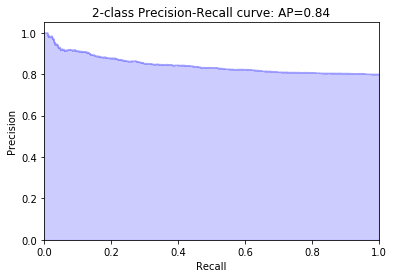

In [26]:
max_AP = experiment_func(max_test)

In [27]:
def en_test(epoch, loader):
    model.eval ()
    test_loss = 0
    correct = 0
    preds_list = []
    for data, target in loader:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data = Variable(data)
        target = Variable(target)
        (output, _) = model(data)
        preds_list.append(output)
        test_loss += F.nll_loss (output, target).item ()  # sum up batch loss
        pred = output.max (1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq (target.view_as (pred)).sum ().item ()
    ent_pred = predict_entropy(preds_list)
    test_loss /= len (loader.dataset)
    print ('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format (
        test_loss, correct, len (loader.dataset),
        100. * correct / len (loader.dataset)))
    return ent_pred

In [28]:
def predict_entropy(preds_list):
    preds_list = torch.cat(preds_list)
    preds_list = torch.exp(preds_list)
    preds_list = preds_list.detach()
    preds_list = preds_list.numpy()
    preds_list = np.matrix(preds_list)
    #print('\nLe probabilità di classificazione sono: ')
    #print(preds_list)
    #print('')
    entropy = (-entr(preds_list)).sum(1)
    #print('\nL entropia di ciascuna tripletta è: ')
    #print(entropy)
    return entropy


TEST DATASET 012

Test set: Average loss: 0.0862, Accuracy: 2530/8000 (32%)


TEST DATASET 345

Test set: Average loss: 0.2449, Accuracy: 9/2000 (0%)

L Avarage Precision è:  0.8394336031885419


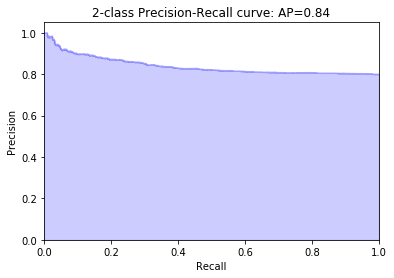

In [29]:
en_AP = experiment_func(en_test)

In [30]:
print('La differenza tra en_AP e max_AP è: ', en_AP - max_AP)

La differenza tra en_AP e max_AP è:  -0.004480963543855854


## Test con temperature scaling

In [31]:
def softmax_temp(score, temp_index):
    x = np.exp(score/temp_index)
    return x/x.sum(axis = 1)

In [32]:
def temperature_test(T):
    AP_list = []
    for t in T:
        print('La temperatura è: ', t)
        ## Test_loader079
        print('\nTEST DATASET 079')
        result_ID = en_test_temp(epoch, test_loaderID, t)
        len_ID = len(result_ID)

        resID = np.empty((0, len_ID))
        for i in range (0, len_ID):
            newvalue = result_ID[i]
            resID = np.append(resID, newvalue)

        ## Test_loader80-99
        print('\nTEST DATASET OOD')
        result_OOD = en_test_temp(epoch, test_loaderOD, t)
        len_OOD = len(result_OOD)

        resOOD = np.empty((0, len_OOD))
        for i in range (0, len_OOD):
            newvalue = result_OOD[i]
            resOOD = np.append(resOOD, newvalue) 

        ## Raccolgo le predizioni max o con entropia in y_scores
        y_scores =np.concatenate((resID, resOOD), axis = None)

        pred_ID = np.ones(len_ID, dtype=int)
        pred_OOD = np.zeros(len_OOD, dtype=int)

        ## Raccolgo le etichette, agli inD assegno 1, agli outD assegno 0
        y_true = np.concatenate((pred_ID, pred_OOD), axis = None)

        AP = average_precision_score(y_true, y_scores)

        print('L Avarage Precision è: ', AP)

        plot_func(y_true, y_scores, AP)

        AP_list.append(AP)

    return AP_list

In [33]:
def en_test_temp(epoch, loader, t):
    model.eval ()
    test_loss = 0
    correct = 0
    preds_list = []
    for data, target in loader:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data = Variable(data)
        target = Variable(target)
        (_, out_temp) = model(data)
        preds_list.append(out_temp)      
        test_loss += F.nll_loss (out_temp, target).item ()  # sum up batch loss
        pred = out_temp.max (1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq (target.view_as (pred)).sum ().item ()
    preds_list = torch.cat(preds_list)
    preds_list = preds_list.detach()
    preds_list = preds_list.numpy()
    preds_list = np.matrix(preds_list)
    length = len(preds_list)
    print(preds_list)
    for k in range (0, length):
        preds_list[k] = softmax_temp(preds_list[k], t)
    print(preds_list)
    ent_pred = (-entr(preds_list)).sum(1)
    test_loss /= len (loader.dataset)
    print ('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format (
        test_loss, correct, len (loader.dataset),
        100. * correct / len (loader.dataset)))
    return ent_pred

La temperatura è:  1.0

TEST DATASET 079
[[  1.8981999  -2.6809163  -2.0828035 ... -20.357317  -19.225399
  -19.481783 ]
 [-11.102984   -3.100117   -4.8064075 ... -23.776264  -22.816343
  -22.83141  ]
 [-10.425711   -3.1091623  -3.2009666 ... -19.425844  -17.919855
  -19.173542 ]
 ...
 [  1.2659158  -1.1588801  -2.695593  ... -27.577246  -26.182787
  -26.178608 ]
 [ -8.158118   -2.8307455  -9.656981  ... -34.004166  -32.67359
  -31.436426 ]
 [ -3.476168  -10.297667    0.7059248 ... -24.0482    -22.97267
  -23.857723 ]]
[[1.35686681e-01 1.39268301e-03 2.53284955e-03 ... 2.93149428e-11
  9.09232134e-11 7.03604536e-11]
 [8.29117880e-07 2.47866288e-03 4.49971383e-04 ... 2.59824931e-12
  6.78530149e-12 6.68383968e-12]
 [1.74604168e-06 2.62779323e-03 2.39729276e-03 ... 2.15449908e-10
  9.71379754e-10 2.77280754e-10]
 ...
 [8.40860903e-02 7.44129764e-03 1.60052592e-03 ... 2.50206333e-14
  1.00902990e-13 1.01325544e-13]
 [5.63288922e-05 1.15979128e-02 1.25829720e-05 ... 3.35687733e-16
  1.2699


Test set: Average loss: -0.0239, Accuracy: 2530/8000 (32%)


TEST DATASET OOD
[[  3.8416638   -1.709887     1.132083   ... -20.018114   -19.263958
  -20.23648   ]
 [ -4.5293903   -5.4235206   -4.175002   ... -23.87057    -22.286728
  -24.104946  ]
 [ -2.870228    -2.9830768   -0.06149231 ... -14.066524   -13.989153
  -14.623069  ]
 ...
 [ -6.2771945   -5.572445    -8.450824   ... -31.951159   -32.670067
  -31.913998  ]
 [ -9.995629    -0.0525244   -3.647927   ... -23.248297   -22.160933
  -23.267714  ]
 [ -7.520902    -2.3463326   -4.9198594  ... -31.658049   -29.756437
  -29.96516   ]]
[[4.97355163e-02 1.24140838e-02 2.52625775e-02 ... 1.27680381e-04
  1.54172056e-04 1.20896948e-04]
 [8.70011840e-03 6.95738755e-03 9.50609986e-03 ... 6.91167588e-05
  1.02694394e-04 6.51832815e-05]
 [8.41972604e-03 8.18550680e-03 1.69923156e-02 ... 5.12478466e-04
  5.22487622e-04 4.45912330e-04]
 ...
 [1.00151068e-02 1.19446320e-02 5.81643358e-03 ... 1.63357981e-05
  1.36485305e-05 1.64882676e-05]
 [1.


Test set: Average loss: -0.0239, Accuracy: 2530/8000 (32%)


TEST DATASET OOD
[[ -8.681248    -4.441779    -5.103719   ... -26.04439    -24.37073
  -24.863552  ]
 [  0.14248456  -1.9862531   -0.8284235  ... -19.546236   -19.441038
  -19.475212  ]
 [ -3.123602    -6.165553    -0.7106979  ... -27.336782   -25.66502
  -26.277527  ]
 ...
 [ -4.7959824   -3.8809803   -1.1132413  ... -19.454535   -20.549288
  -19.829601  ]
 [ -5.5524163   -3.2565563  -11.660782   ... -36.539497   -35.791668
  -34.59211   ]
 [ -4.2242894   -1.2861123   -0.16407527 ... -16.291761   -15.74994
  -15.130567  ]]
[[0.00614606 0.01044105 0.00961191 ... 0.00070147 0.0008647  0.00081304]
 [0.01815199 0.01391111 0.01607743 ... 0.00154912 0.00156963 0.00156294]
 [0.01300293 0.00889003 0.01758045 ... 0.00063035 0.00077685 0.0007196 ]
 ...
 [0.00901071 0.01010257 0.01427853 ... 0.00144209 0.00125766 0.00137604]
 [0.01396456 0.01860639 0.00650764 ... 0.00029029 0.00031874 0.0003703 ]
 [0.00978711 0.01413054 0.01625813 ...

[[ -2.8674355   -6.034635    -0.2513634  ... -31.323526   -28.364988
  -31.999582  ]
 [ -2.1092243   -2.4541261   -1.7510501  ... -11.937564   -11.289137
  -11.920916  ]
 [ -1.7616386   -2.7473445   -0.45072523 ... -15.692051   -14.338971
  -15.138939  ]
 ...
 [ -7.1652837   -1.836287    -8.983429   ... -14.609902   -13.926366
  -13.4677725 ]
 [ -0.595244    -0.7125553   -4.0267086  ... -19.553469   -18.892485
  -18.522987  ]
 [ -3.9342406   -5.319563    -0.42978284 ... -24.528936   -21.708809
  -23.462912  ]]
[[0.01343589 0.0103191  0.0167088  ... 0.00125431 0.00160502 0.0011856 ]
 [0.01090688 0.01059785 0.01123733 ... 0.0048084  0.00507538 0.00481508]
 [0.0120916  0.01113807 0.01348737 ... 0.00378726 0.00423931 0.00396591]
 ...
 [0.00889677 0.01387059 0.00764595 ... 0.00478412 0.00506455 0.00526184]
 [0.01513198 0.01498477 0.01136859 ... 0.00311727 0.00329379 0.00339679]
 [0.01107123 0.00986414 0.01482608 ... 0.00198998 0.00251717 0.00217485]]

Test set: Average loss: 0.1397, Accurac

[[ -3.745451    -1.8689847    1.411774   ... -12.189463   -10.926546
  -11.497549  ]
 [ -4.2386823   -6.4660516    0.7877929  ... -17.00027    -17.250448
  -17.184511  ]
 [ -4.8934956   -2.392107    -3.3313243  ... -17.789145   -16.962925
  -17.26268   ]
 ...
 [  2.278678    -3.673616    -1.3440865  ... -23.354685   -21.01176
  -21.378317  ]
 [ -8.431491    -4.1631045   -1.7490839  ... -20.266197   -20.113653
  -20.708572  ]
 [ -6.1142154    0.62656677  -2.7660036  ... -23.322525   -21.794294
  -23.35534   ]]
[[0.00997379 0.01121486 0.01376718 ... 0.00588384 0.00636709 0.00614387]
 [0.01019393 0.00886917 0.01395652 ... 0.00459144 0.0045202  0.00453887]
 [0.009886   0.01155891 0.01089992 ... 0.00441559 0.00464959 0.0045633 ]
 ...
 [0.01658288 0.01143127 0.01322287 ... 0.00334105 0.00386793 0.00378032]
 [0.00820863 0.01071838 0.0124639  ... 0.00391775 0.00395528 0.00381091]
 [0.00995914 0.01517713 0.01227733 ... 0.00339727 0.00373776 0.00339031]]

Test set: Average loss: 0.1401, Accuracy

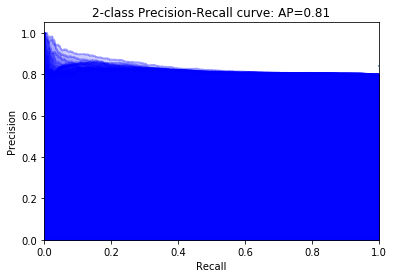

In [34]:
#T = [0.1, 0.5, 1.0, 10.0, 20.0, 50.0, 100.0]
#T = [0.8, 1.0, 10.0, 20.0, 50.0, 100.0]
T = np.arange(1.0, 20.0, 1.0)
R = temperature_test(T)
plt.plot(T, R)

In [35]:
print(R)

[0.8394335997382432, 0.8314202297161097, 0.8270432873623094, 0.8244605285609659, 0.8225404680716177, 0.8209993356666969, 0.8195535908395404, 0.8181905808462488, 0.8169167631416105, 0.8157908943568958, 0.8147356548798078, 0.8137804577730644, 0.8129692378782499, 0.8123003966673832, 0.8116760413978767, 0.8112224452188085, 0.810837847049872, 0.8104936148183333, 0.8101772045983302]


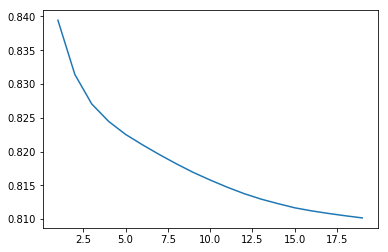

In [36]:
plt.plot(T, R)